<a href="https://colab.research.google.com/github/maxiperezc/memoscopio/blob/master/HPC/PerezCoto_Maximiliano_ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

# Cargas Electricas Libres en 2D

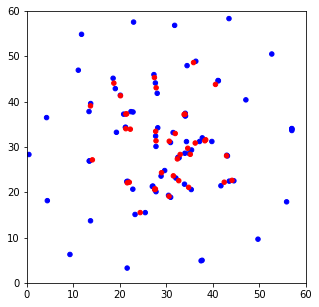

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

positivas = 80#@param {type: "number"}
negativas = 40#@param {type: "number"}
frames    = 200#@param {type: "number"}
numcargas = positivas + negativas
colores = ['blue'] * positivas + ['red'] * negativas 

def move():
  x_cpu  = np.random.uniform(20.0, 40.0, size=numcargas)
  y_cpu  = np.random.uniform(20.0, 40.0, size=numcargas)
  carga  = [1] * positivas + [-1] * negativas 

  while True:
    for i in range( 0, numcargas ):
      ex = 0
      ey = 0

      for j in range( 0, numcargas ):
        if i != j:
          dx = x_cpu[j] - x_cpu[i]
          dy = y_cpu[j] - y_cpu[i]

          rsq = pow(dx,2) + pow(dy,2)
          rrt = rsq * np.sqrt(rsq)

          if rrt > 1:
            ch = carga[i]*carga[j]
            ex -= ch*dx/rrt
            ey -= ch*dy/rrt

      x_cpu[i] += ex
      y_cpu[i] += ey

    yield np.c_[x_cpu, y_cpu]

def update(i):
    data = next(stream)
    scat.set_offsets(data)
    return scat,

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
stream = move()
x, y = next(stream).T
scat = ax.scatter(x, y, c=colores, s=20, vmin=0, vmax=1)
ax.axis([0, 60, 0, 60])
anim = animation.FuncAnimation(fig, update, frames=np.arange(0, 1, 1/frames), interval=100, blit=True)
rc('animation', html='jshtml')
anim


# Cargas Libres usando OpenMP

In [ ]:
code = """
// Cargas Libres en el Vacio con OpenMP, usando c, ejecutado en Colab.

#include <iostream>
#include <vector>
#include <cstdlib>
#include <math.h>
#include <sys/time.h>
#include <omp.h>    // Cabecera OpenMP   

// ----------------------------------------------------------------------------
// Macros que miden el tiempo.

static double dHashTiempoHistory[3];
static struct timeval tv;

#define TIEMPO_INI( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = tv.tv_sec + tv.tv_usec/1000000.0;
   
   
#define TIEMPO_FIN( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = ((tv.tv_sec + tv.tv_usec/1000000.0) - dHashTiempoHistory[ h ]) * 1000; // Devuelvo en milisegundos
#define TIEMPO_GET( h ) dHashTiempoHistory[ h ]

#define HTH_TOTAL           1
#define HTH_CARGAS_SEC      2
#define HTH_CARGAS_OMP      3

// ----------------------------------------------------------------------------

int main(int argc, char* argv[]) 
{ 
  int i, j, f;
  int ch;
  double ex, ey, dx, dy;
  double rsq, rrt;

  TIEMPO_INI( HTH_TOTAL )

  // Leo los parametros.
  if( argc != 4 )
  {
      std::cerr<< " Error en los parametros de indicar: (cargas positivas), (cargas negativas), (frames de renderizacion)."<<argc<<std::endl;
      exit( -1 );
  }

  int positivas = atoi( argv[1] );
  int negativas = atoi( argv[2] );
  int frames    = atoi( argv[3] );
  int numcargas = positivas + negativas;

  // --------------------------------------------
  // Defino la memoria de los vectores.

  std::vector<double> X( numcargas );
  std::vector<double> Y( numcargas );
  std::vector<int>    C( numcargas );

  for (int i=0; i<numcargas; i++)
  {
    X[i]  = (rand()/(double)RAND_MAX)*0.73;
    Y[i]  = (rand()/(double)RAND_MAX)*0.73;
    C[i]  = i < positivas ? 1 : -1;
  }

  // --------------------------------------------
  // Realizo la función CARGAS en forma secuencial.

  TIEMPO_INI( HTH_CARGAS_SEC )

  for(f=0; f<frames; f++)
  {
    for(i=0; i<numcargas; i++)
    {
      ex = 0;
      ey = 0;

      for(j=0; j<numcargas; j++)
      {
        if(i != j)
        {
          dx = X[j] - X[i];
          dy = Y[j] - Y[i];
          rsq = pow(dx, 2) + pow(dy, 2);
          rrt = rsq * sqrt(rsq);

          if(rrt > 1)
          {
            ch = C[i]*C[j];
            ex -= ch*dx/rrt;
            ey -= ch*dy/rrt;
          }
        }
      }

      X[i] += ex;
      Y[i] += ey;
    }
  }

  TIEMPO_FIN( HTH_CARGAS_SEC )

  // --------------------------------------------

  for (int i=0; i<numcargas; i++)
  {
    X[i]  = (rand()/(double)RAND_MAX)*0.73;
    Y[i]  = (rand()/(double)RAND_MAX)*0.73;
  }
  
  // Realizo la función CARGAS con OpenMP.

  TIEMPO_INI( HTH_CARGAS_OMP )

  for(f=0; f<frames; f++)
  {

    #pragma omp parallel for
    for(i=0; i<numcargas; i++)
    {
      ex = 0;
      ey = 0;

      for(j=0; j<numcargas; j++)
      {
        if(i != j)
        {
          dx = X[j] - X[i];
          dy = Y[j] - Y[i];
          rsq = pow(dx, 2) + pow(dy, 2);
          rrt = rsq * sqrt(rsq);

          if(rrt > 1)
          {
            ch = C[i]*C[j];
            ex -= ch*dx/rrt;
            ey -= ch*dy/rrt;
          }
        }
      }

      X[i] += ex;
      Y[i] += ey;
    }
  }

  TIEMPO_FIN( HTH_CARGAS_OMP )

  // --------------------------------------------
  // Muestro los resultados.

  std::cout<<" X : ["; 
  for(i=0;i<X.size();i++)
  {
    std::cout<<X[i]<< ", ";
  }
  std::cout<<"]"<<std::endl; 

  std::cout<<" Y : ["; 
  for(i=0;i<Y.size();i++)
  {
    std::cout<<Y[i]<< ", ";
  }
  std::cout<<"]"<<std::endl; 


  TIEMPO_FIN( HTH_TOTAL )

 std::cout<<"Valores Reales  :" <<std::endl;
 std::cout<<"Tiempo TOTAL     : "<<TIEMPO_GET(HTH_TOTAL   )<<" [ms]"<<std::endl;
 std::cout<<"Tiempo cargas Sec  : "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" [ms]"<<std::endl;
 std::cout<<"Tiempo cargas Omp  : "<<TIEMPO_GET(HTH_CARGAS_OMP)<<" [ms]"<<std::endl;
 std::cout<<std::endl;
 std::cout<<"SpeedUp          : (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" / "<<TIEMPO_GET(HTH_CARGAS_OMP)<<" = "<<TIEMPO_GET(HTH_CARGAS_SEC)/TIEMPO_GET(HTH_CARGAS_OMP)<<std::endl;
 std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_CARGAS_SEC)/TIEMPO_GET(HTH_CARGAS_OMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_CARGAS_SEC)/(omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP))<<std::endl;
 std::cout<<"Coste Sec        : nro procesadores*Tiempo             : "<<1<<" * "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" = "<<TIEMPO_GET(HTH_CARGAS_SEC)<<std::endl;
 std::cout<<"Coste Omp        : nro procesadores*Tiempo             : "<<omp_get_num_procs()<<" * "<<TIEMPO_GET(HTH_CARGAS_OMP)<<" = "<<omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP)<<std::endl;
 std::cout<<"Funcion Overhead : Coste Omp - tiempo Secuencial       : "<<omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP)<<" - "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" = "<<(omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP))-TIEMPO_GET(HTH_CARGAS_SEC)<<std::endl;


 std::cout<<std::endl;
 std::cout<<"Valores Ideal: "<<std::endl;
 TIEMPO_GET(HTH_CARGAS_OMP) = TIEMPO_GET(HTH_CARGAS_SEC) / 2;
 std::cout<<"Tiempo CARGAS Sec  : "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" [ms]"<<std::endl;
 std::cout<<"Tiempo CARGAS Omp  : "<<TIEMPO_GET(HTH_CARGAS_OMP)<<" [ms]"<<std::endl;

 std::cout<<"SpeedUp          : (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" / "<<TIEMPO_GET(HTH_CARGAS_OMP)<<" = "<<TIEMPO_GET(HTH_CARGAS_SEC)/TIEMPO_GET(HTH_CARGAS_OMP)<<std::endl;
 std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_CARGAS_SEC)/TIEMPO_GET(HTH_CARGAS_OMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_CARGAS_SEC)/(omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP))<<std::endl;
 std::cout<<"Coste Sec        : nro procesadores*Tiempo             : "<<1<<" * "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" = "<<TIEMPO_GET(HTH_CARGAS_SEC)<<std::endl;
 std::cout<<"Coste Omp        : nro procesadores*Tiempo             : "<<omp_get_num_procs()<<" * "<<TIEMPO_GET(HTH_CARGAS_OMP)<<" = "<<omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP)<<std::endl;
 std::cout<<"Funcion Overhead : Coste Omp - tiempo Secuencial       : "<<omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP)<<" - "<<TIEMPO_GET(HTH_CARGAS_SEC)<<" = "<<(omp_get_num_procs()*TIEMPO_GET(HTH_CARGAS_OMP))-TIEMPO_GET(HTH_CARGAS_SEC)<<std::endl;


}
// ----------------------------------------------------------------------------

"""
text_file = open("code_cargas.cpp", "w")
text_file.write(code)
text_file.close()

# 2.1.Compilación de código C

In [ ]:
!g++ -o cargas -fopenmp code_cargas.cpp

# Ejecución de código

In [ ]:
%env OMP_NUM_THREADS=2
!./cargas 200 200 100

env: OMP_NUM_THREADS=2
 X : [17.267, -3.95507, 16.9688, -80.434, -12.2855, 92.6902, 4.55526, -17.9501, -47.7695, 13.0399, -10.5716, 16.2876, 141.243, -509.816, 5.8814, 893.664, 4.29822, -2.46993, 21.0018, -6.95379, -45.9884, -18.3983, -28.2432, -0.0437864, 61.7709, -0.310342, 212.775, 4.55791, -0.139025, 9.88564, 5.53784, -162.664, -31.0409, 4.75263, -25.062, 0.769309, -24.4444, -4.84884, 6.18555, -9.02874, -25.5885, -10.5976, 2.15612, -70.5896, -80.2645, 26.2835, -1371.79, 2.44446, 6.75745, 81.5882, 10.0524, 29.3321, 802.627, 0.932416, -0.951625, -24961.3, -158.114, -2.9975, 5.91731, 2.90867, -32.6902, -2.47177, -6986.5, -3.36839, 3.05733, 19.3652, -47.4505, -294.701, -43.7583, -15.2055, 34.6515, -34.2917, -4.20494, 37.5961, -35.6875, 48.5695, 122.414, 9.8571, -47568.5, 61.2425, -826.969, -37.803, -60.6114, 36981.3, 1.37425, -29.5699, -32.0005, -44.0146, -4.80822, 41.9554, 415.767, 22.0963, -22.5829, -13.5202, -47.6162, 5.76782, 37.5241, -171.995, -30.1604, -20.6421, 156.855, -50.6131

# Medidas de prestaciones en algoritmos paralelos
Las tecnicas de HPC buscan reducir los tiempos de ejecución, el tiempo como meida, no alcanza. Dos algoritmos pueden ejecutar en el mismo tiempo, pero uno de ellos usa menos procesadores [6,7]. 

## SpeedUp
Referencia a la ganacia de velocidad que se consigue con un algoritmo paralelo, al resolver el mismo problema con respecto al algoritmo secuencial.

<center>$ SpeedUp = TiempoSecuencial  /  TiempoParalelo $</center>

##Eficiencia
La eficiencia normaliza el valor del SpeedUp, al dividirlo por la cantidad de procesadores que se utilizaron para alcanzar la ganacia en velocidad. Dando la idea de la porción de tiempo que los procesadores se dedican al trabajo útil.

<center>$ Eficiencia = SpeedUp  /Nro. procesadores $</center>

## Coste
El coste de un algoritmo paralelo representa el tiempo realizado por todo el sistema en la resoluciòn del problema.

<center>$ coste = Nro. procesadores * Tiempo algoritmo$</center>


##Función Overhead
Es la diferencia entre el Coste y el tiempo secuencial. Mientras mayor es la función overhead, peor es el comportamiento del algoritmo paralelo.
<center>$ Overhead = Coste  /  TiempoSecuencial $</center>


---
# 6 Bibliografía

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Función propia: [Referencia](https://software.intel.com/content/www/us/en/develop/documentation/mkl-developer-reference-c/top/blas-and-sparse-blas-routines/blas-routines/blas-level-1-routines-and-functions/cblas-axpy.html)

[4] Biblioteca BLAS: [Referencia](http://www.netlib.org/blas/)

[5] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[6] F. Almeida, D. Gimenéz, A. Vidal - Introducción a la programación paralela - 2008 - Editorial Parafino.

[7] D. Jiménez-González - Introducción a las arquitecturas paralelas. [PDF](http://so-unlam.com.ar/material-clase/HPC/Arquitecturas_de_computadores_avanzadas_(Modulo_1).pdf)